In [28]:
!pip install lightgbm xgboost -q

In [37]:
import pandas as pd
import matplotlib.pyplot as plt 

dataset = pd.read_csv('./small-sample-BGU.csv', parse_dates=['reportts']) \
  .sort_values('reportts')

In [38]:
dataset

,reportts,acnum,pos,egtm,fltdes,dep,arr,ivs12,ibe,iaie,...,votm,vsva,w14,pf,wai,nai,prv,hpv,xf,reason
0,2018-12-24 10:53:22,VQ-BGU,1,44.437,8990.0,EDHI,UUDD,NaN,NaN,NaN,...,NaN,0.0,1160.0,0.53,0.0,0.0,1.0,0.0,0.0,NaN
522,2018-12-24 10:53:22,VQ-BGU,2,45.869,8990.0,EDHI,UUDD,NaN,NaN,NaN,...,NaN,0.0,1160.0,0.53,0.0,0.0,1.0,0.0,0.0,NaN
523,2018-12-25 15:23:23,VQ-BGU,2,44.904,1024.0,URSS,UUDD,NaN,NaN,NaN,...,NaN,0.0,1179.0,0.53,0.0,0.0,1.0,0.0,0.0,NaN
1,2018-12-25 15:23:23,VQ-BGU,1,44.379,1024.0,URSS,UUDD,NaN,NaN,NaN,...,NaN,0.0,1179.0,0.53,0.0,0.0,1.0,0.0,0.0,NaN
524,2018-12-25 20:49:27,VQ-BGU,2,44.318,217.0,UUDD,UNBB,NaN,NaN,NaN,...,NaN,0.0,1303.0,0.51,0.0,0.0,1.0,0.0,0.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
519,2019-12-30 17:46:02,VQ-BGU,1,22.152,5783.0,UNNT,VVCR,NaN,NaN,NaN,...,NaN,0.0,1340.0,0.53,0.0,1.0,1.0,0.0,0.0,NaN
1042,2019-12-31 02:11:28,VQ-BGU,2,20.216,5784.0,VVCR,UNNT,NaN,NaN,NaN,...,NaN,0.0,1140.0,0.03,0.0,0.0,0.0,0.0,0.0,NaN
520,2019-12-31 02:11:28,VQ-BGU,1,22.151,5784.0,VVCR,UNNT,NaN,NaN,NaN,...,NaN,0.0,1137.0,0.03,0.0,0.0,0.0,0.0,0.0,NaN
521,2020-01-31 17:24:04,VQ-BGU,1,18.218,5783.0,UNNT,VVCR,NaN,NaN,NaN,...,NaN,0.0,1336.0,0.51,0.0,0.0,1.0,0.0,0.0,NaN


In [39]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor

In [41]:
Y = dataset[['egtm']]
# , 'n1_delt', 'n2_delt'

X = dataset.drop(columns=[
    'reportts', 'acnum', 'pos', 'dep', 'arr', 
    'egtm', 'fltdes', 'reportts',
    'dmusw', 'exswpn', 'reason'
]).fillna(-100)

X = X.loc[:, ~X.columns.str.contains('stw')]

In [42]:
def get_score_by_parameter(predict_field, alg='catboost'):
  y = Y[predict_field]

  x = X[y.notna()]

  y = y.dropna()
  
  X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.33, random_state=42)
  
  # assert len(x) == len(y)
  # train_i = int(len(x) * 60 / 100)
  # X_train, y_train = x[0:train_i], y[0:train_i]
  # X_test, y_test = x[train_i:], y[train_i:]

  model = None
  if alg == 'catboost':
    model = CatBoostRegressor(iterations=200, random_state=42, verbose=False)
  elif alg == 'lightgbm':
    model = LGBMRegressor(random_state=42)
  elif alg == 'xgboost':
    model = XGBRegressor()
  elif alg == 'rand_forest':
    model = RandomForestRegressor(n_estimators=100, random_state=42)
  
  model.fit(X_train, y_train)
  predicted = model.predict(X_test)
  preds = pd.DataFrame({'y': y_test, 'pred': predicted})
  mse = mean_squared_error(y_test, predicted, squared=False)
  mae = mean_absolute_error(y_test, predicted)
  
  return mse, mae, model, preds

In [43]:
scores = pd.DataFrame(columns=["model", "parameter", "rmse", "mae"])
model_types = ["rand_forest", "lightgbm", "catboost", "xgboost"]

models = {}
preds = {}
output_parameters = Y.columns

for model in model_types:
  for param in output_parameters:
    mse, mae, result_model, pred = get_score_by_parameter(param, model)
    models[model + "_" + param] = result_model
    preds[model + "_" + param] = pred
    scores.loc[len(scores)] = [model, param, mse, mae]

scores

,model,parameter,rmse,mae
0,rand_forest,egtm,1.616652,0.755086
1,lightgbm,egtm,1.343772,0.807368
2,catboost,egtm,1.073408,0.801623
3,xgboost,egtm,1.780322,0.800268


[Text(0, 0, '1.61665'),
 Text(0, 0, '1.34377'),
 Text(0, 0, '1.07341'),
 Text(0, 0, '1.78032')]

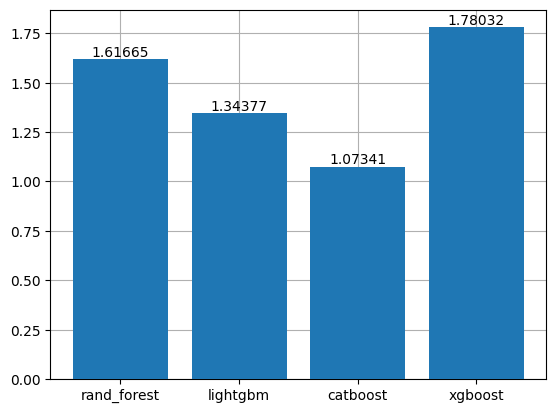

In [44]:
fig, ax = plt.subplots(1, 1)
ax.grid(zorder=0)
ax.bar(model_types, scores[scores['parameter'] == 'egtm']['rmse'], align='center', zorder=3)
ax.bar_label(ax.containers[0], label_type='edge')

In [45]:


preds['lightgbm_egtm']

,y,pred
1007,22.722,23.927541
662,30.905,31.102243
268,26.345,26.529956
412,25.028,25.782134
322,26.501,26.650786
...,...,...
979,21.791,22.459426
310,27.343,27.516106
424,21.193,22.262662
610,35.976,35.674932


1. Добавить линейную регрессию 
1. Разделить расчёт метрик по двигателям и фазам полёта
1. A321 - меньше допустимый запас egtm
1. В идеале EGTM +/- 2 градуса
1. Разделение по фазе полёта 
1. Построить корелляции каждого признака с таргетом
1. В дальнейшем использовать это для feature selection